## Data Processing

In [1]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('./src')
import numpy as np
from data_loader_df import *
import pandas as pd
from sklearn import svm, linear_model, metrics, neural_network, ensemble
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

In [2]:
train_file_path = "data/adult.data"
test_file_path = "data/adult.test"

train, val, test = load_all_data(train_file_path, test_file_path, valid_rate=0.1, is_df=True, norm=True, one_hot=True)
train_X, train_Y, val_X, val_Y, test_X, test_Y = load_all_data(train_file_path, test_file_path, valid_rate=0.1, is_df=False, norm=True, one_hot=True)

In [3]:
train

,age,fnlwgt,edunum,cgain,closs,hpw,income,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,mstatus_ Divorced,mstatus_ Married-AF-spouse,mstatus_ Married-civ-spouse,mstatus_ Married-spouse-absent,mstatus_ Never-married,mstatus_ Separated,mstatus_ Widowed,occ_ Adm-clerical,occ_ Armed-Forces,occ_ Craft-repair,occ_ Exec-managerial,occ_ Farming-fishing,occ_ Handlers-cleaners,occ_ Machine-op-inspct,occ_ Other-service,occ_ Priv-house-serv,occ_ Prof-specialty,occ_ Protective-serv,occ_ Sales,occ_ Tech-support,occ_ Transport-moving,relation_ Husband,relation_ Not-in-family,relation_ Other-relative,relation_ Own-child,relation_ Unmarried,relation_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male,nation_ Cambodia,nation_ Canada,nation_ China,nation_ Columbia,nation_ Cuba,nation_ Dominican-Republic,nation_ Ecuador,nation_ El-Salvador,nation_ England,nation_ France,nation_ Germany,nation_ Greece,nation_ Guatemala,nation_ Haiti,nation_ Holand-Netherlands,nation_ Honduras,nation_ Hong,nation_ Hungary,nation_ India,nation_ Iran,nation_ Ireland,nation_ Italy,nation_ Jamaica,nation_ Japan,nation_ Laos,nation_ Mexico,nation_ Nicaragua,nation_ Outlying-US(Guam-USVI-etc),nation_ Peru,nation_ Philippines,nation_ Poland,nation_ Portugal,nation_ Puerto-Rico,nation_ Scotland,nation_ South,nation_ Taiwan,nation_ Thailand,nation_ Trinadad&Tobago,nation_ United-States,nation_ Vietnam,nation_ Yugoslavia
24337,1.792267,-1.154262,-0.443917,-0.147976,-0.218112,-0.079887,<=50K,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
17049,0.879813,0.248813,-0.443917,-0.147976,-0.218112,-0.079887,>50K,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
21016,-0.184716,-0.041686,-0.443917,-0.147976,-0.218112,0.754722,>50K,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2790,1.944343,0.647885,-0.050640,-0.147976,-0.218112,-0.079887,<=50K,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13511,-0.793019,-1.428567,0.342636,-0.147976,-0.218112,1.589331,<=50K,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
29288,-1.477359,-0.845366,-0.443917,-0.147976,-0.218112,-0.079887,<=50K,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2161,-1.325283,-1.226723,-0.050640,-0.147976,-0.218112,-0.330270,<=50K,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
12546,0.043397,-0.724826,1.129190,-0.147976,-0.218112,0.337418,>50K,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
210,0.423586,-0.274028,-0.443917,-0.147976,-0.218112,-0.079887,<=50K,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,

In [4]:
COLUMNS = [
		"age", "work", "fnlwgt", "edu", "edunum",
		"mstatus", "occ", "relation", "race", "sex",
		"cgain", "closs", "hpw", "nation", "income"
]
COLS_TO_NORM = ['age', 'fnlwgt', 'edunum', 'cgain', 'closs', 'hpw']
CATEGORICAL_COLS = [
		"work", "edu", "mstatus", "occ", "relation", "race", "sex", "nation"
	]

In [5]:
print("----mean & std of features of training data----")
print(np.mean(train[COLS_TO_NORM]))
print(np.var(train[COLS_TO_NORM]))
print("----mean & std of features of validation data----")
print(np.mean(val[COLS_TO_NORM]))
print(np.var(val[COLS_TO_NORM]))
print("----mean & std of features of testing data----")
print(np.mean(test[COLS_TO_NORM]))
print(np.var(test[COLS_TO_NORM]))

----mean & std of features of training data----
age      -8.371845e-17
fnlwgt   -3.436385e-17
edunum    1.341216e-15
cgain     1.534017e-15
closs     5.223890e-16
hpw       7.151900e-16
dtype: float64
age       1.0
fnlwgt    1.0
edunum    1.0
cgain     1.0
closs     1.0
hpw       1.0
dtype: float64
----mean & std of features of validation data----
age       0.006593
fnlwgt   -0.000001
edunum   -0.029432
cgain     0.031234
closs     0.012211
hpw      -0.021736
dtype: float64
age       0.974168
fnlwgt    1.070084
edunum    1.056266
cgain     1.501354
closs     1.068176
hpw       0.996439
dtype: float64
----mean & std of features of testing data----
age       0.025781
fnlwgt   -0.001686
edunum   -0.006299
cgain     0.007025
closs     0.002878
hpw      -0.000466
dtype: float64
age       1.035110
fnlwgt    1.006223
edunum    1.012547
cgain     1.135835
closs     1.016680
hpw       1.013528
dtype: float64


### Helper Functions

In [6]:
def auc(X, Y, reg):
    Y_hat = reg.predict(X);
    fpr, tpr, _ = metrics.roc_curve(Y, Y_hat)
    return metrics.auc(fpr, tpr)

In [7]:
def matshow(X, Y, X_label, Y_label, train_auc, val_auc, test_auc):
    f, ax = plt.subplots(1, 1, figsize=(8, 5))
    cax = ax.matshow(train_auc, interpolation='nearest') 
    f.colorbar(cax, fraction=0.01, pad=0.04)
    ax.set_xticks(np.arange(len(X)))
    ax.set_xticklabels(list(X)); ax.set_yticklabels(['']+list(Y))
    ax.set_title("matshow of train auc", pad=20)
    ax.set_xlabel(X_label)
    ax.set_ylabel(Y_label)
    plt.show()
    
    f, ax = plt.subplots(1, 1, figsize=(8, 5))
    cax = ax.matshow(val_auc, interpolation='nearest') 
    f.colorbar(cax, fraction=0.01, pad=0.04)
    ax.set_xticks(np.arange(len(X)))
    ax.set_xticklabels(list(X)); ax.set_yticklabels(['']+list(Y))
    ax.set_title("matshow of val auc", pad=20)
    ax.set_xlabel(X_label)
    ax.set_ylabel(Y_label)
    plt.show()
    
    f, ax = plt.subplots(1, 1, figsize=(8, 5))
    cax = ax.matshow(test_auc, interpolation='nearest') 
    f.colorbar(cax, fraction=0.01, pad=0.04)
    ax.set_xticks(np.arange(len(X)))
    ax.set_xticklabels(list(X)); ax.set_yticklabels(['']+list(Y))
    ax.set_title("matshow of test auc", pad=20)
    ax.set_xlabel(X_label)
    ax.set_ylabel(Y_label)
    plt.show()

## Linear Classification

In [25]:
Cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 2, 5, 10, 20, 50]
penalties = ['l1', 'l2']

auc_train = np.zeros((len(penalties), len(Cs)))
auc_val = np.zeros((len(penalties), len(Cs)))
auc_test = np.zeros((len(penalties), len(Cs)))

for i, penalty in enumerate(penalties):
    for j, C in enumerate(Cs):
        print("processing C =", C)
        reg = linear_model.LogisticRegression(penalty=penalty, C=C)
        reg.fit(train_X, train_Y)
    
        auc_train[i][j] = auc(train_X, train_Y, reg)
        auc_val[i][j] = auc(val_X, val_Y, reg)
        auc_test[i][j] = auc(test_X, test_Y, reg)

processing C = 0.1
processing C = 0.2
processing C = 0.3
processing C = 0.4
processing C = 0.5
processing C = 0.7
processing C = 1
processing C = 2
processing C = 5
processing C = 10
processing C = 20
processing C = 50
processing C = 0.1
processing C = 0.2
processing C = 0.3
processing C = 0.4
processing C = 0.5
processing C = 0.7
processing C = 1
processing C = 2
processing C = 5
processing C = 10
processing C = 20
processing C = 50


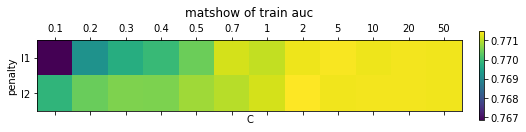

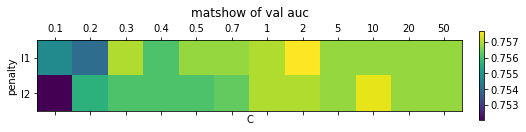

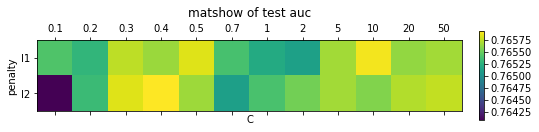

In [26]:
matshow(Cs, penalties, 'C', 'penalty', auc_train, auc_val, auc_test)

## SVM

In [27]:
Cs = [0.1, 0.5, 1, 2, 5, 10, 20]
kernels = ['rbf', 'linear', 'poly']

auc_train = np.zeros((len(kernels), len(Cs)))
auc_val = np.zeros((len(kernels), len(Cs)))
auc_test = np.zeros((len(kernels), len(Cs)))

for i, k in enumerate(kernels):
    for j, C in enumerate(Cs):
        print("processing k=",k,", C=",C);
        learner = svm.SVC(C=C, kernel=k, degree=2, gamma='scale');
        learner.fit(train_X, train_Y);
        auc_train[i][j] = auc(train_X, train_Y, learner)
        auc_val[i][j] = auc(val_X, val_Y, learner)
        auc_test[i][j] = auc(test_X, test_Y, learner)

processing k= rbf , C= 0.1
processing k= rbf , C= 0.5
processing k= rbf , C= 1
processing k= rbf , C= 2
processing k= rbf , C= 5
processing k= rbf , C= 10
processing k= rbf , C= 20
processing k= linear , C= 0.1
processing k= linear , C= 0.5
processing k= linear , C= 1
processing k= linear , C= 2
processing k= linear , C= 5
processing k= linear , C= 10
processing k= linear , C= 20
processing k= poly , C= 0.1
processing k= poly , C= 0.5
processing k= poly , C= 1
processing k= poly , C= 2
processing k= poly , C= 5
processing k= poly , C= 10
processing k= poly , C= 20


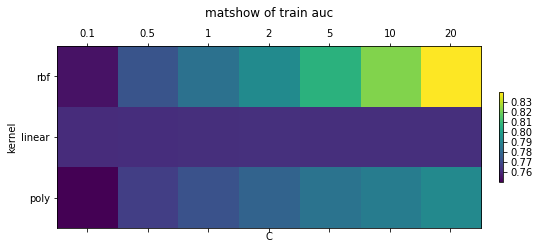

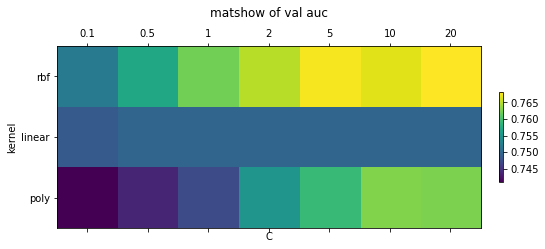

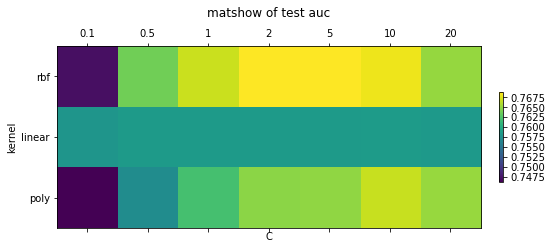

In [28]:
matshow(Cs, kernels, 'C', 'kernel', auc_train, auc_val, auc_test)

## Neural Network

In [30]:
layers = range(1, 7, 1)
nodes = range(4, 22, 2)
auc_train = np.zeros((len(layers), len(nodes)))
auc_val = np.zeros((len(layers), len(nodes)))
auc_test = np.zeros((len(layers), len(nodes)))

for i, layer in enumerate(layers):
    for j, node in enumerate(nodes):
        print("processing layer=",layer,", node=",node)
        hidden_layer = tuple([node for k in range(layer)])
        learner = neural_network.MLPClassifier(hidden_layer_sizes=hidden_layer, activation='relu', solver='adam')
        learner.fit(train_X, train_Y);
        
        auc_train[i][j] = auc(train_X, train_Y, learner)
        auc_val[i][j] = auc(val_X, val_Y, learner)
        print("test auc: ", auc(test_X, test_Y, learner))
        auc_test[i][j] = auc(test_X, test_Y, learner)


processing layer= 1 , node= 4
test auc:  0.771415826037305
processing layer= 1 , node= 6
test auc:  0.7729934335744194
processing layer= 1 , node= 8
test auc:  0.7703254663113819
processing layer= 1 , node= 10
test auc:  0.7694080700418728
processing layer= 1 , node= 12
test auc:  0.777262323943662
processing layer= 1 , node= 14
test auc:  0.7790438237533308
processing layer= 1 , node= 16
test auc:  0.7727162637990103
processing layer= 1 , node= 18
test auc:  0.7688506376094404
processing layer= 1 , node= 20
test auc:  0.7682513323182337
processing layer= 2 , node= 4
test auc:  0.7601484583174725
processing layer= 2 , node= 6
test auc:  0.7765657118385991
processing layer= 2 , node= 8
test auc:  0.7775356870955463
processing layer= 2 , node= 10
test auc:  0.7660080414921964
processing layer= 2 , node= 12
test auc:  0.7794175866006852
processing layer= 2 , node= 14
test auc:  0.7796293300342596
processing layer= 2 , node= 16
test auc:  0.7683355538637229
processing layer= 2 , node= 18
t

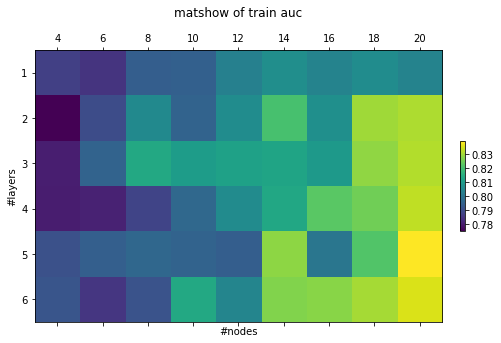

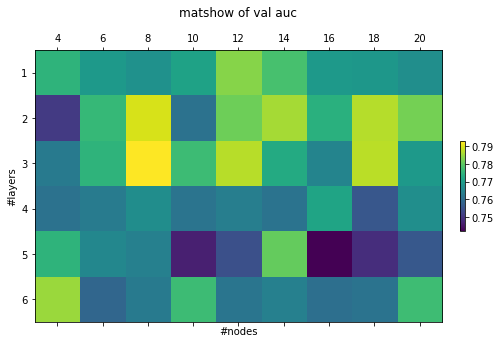

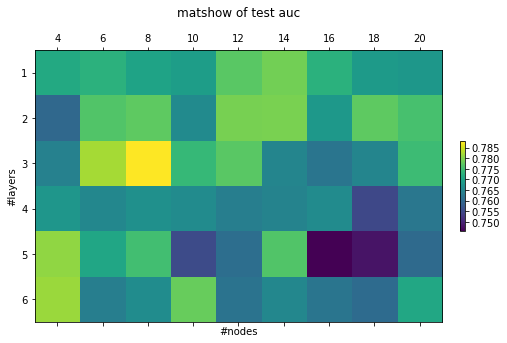

In [32]:
matshow(nodes, layers, '#nodes', '#layers', auc_train, auc_val, auc_test)

In [33]:
auc_test

array([[0.77141583, 0.77299343, 0.77032547, 0.76940807, 0.77726232,
        0.77904382, 0.77271626, 0.76885064, 0.76825133],
       [0.76014846, 0.77656571, 0.77753569, 0.76600804, 0.77941759,
        0.77962933, 0.76833555, 0.77761158, 0.77583627],
       [0.7644528 , 0.78234179, 0.78803079, 0.77412876, 0.77726922,
        0.76500833, 0.76226375, 0.76499215, 0.77471807],
       [0.76805743, 0.76542349, 0.76705129, 0.76627451, 0.76395175,
        0.76465455, 0.76622526, 0.75497193, 0.76260444],
       [0.78097116, 0.77085054, 0.77520651, 0.75554696, 0.76114627,
        0.77656904, 0.74587362, 0.74815974, 0.76049938],
       [0.78166849, 0.76383184, 0.76641345, 0.77821065, 0.76195327,
        0.76538518, 0.76230396, 0.76068091, 0.77123002]])

### Ensemble the models

In [3]:
lc = linear_model.LogisticRegression(penalty='l1', C=2)
svm = svm.SVC(C=5, kernel='rbf', gamma='scale')
nn = neural_network.MLPClassifier(hidden_layer_sizes=(8, 8, 8), activation='relu', solver='adam')
esb = ensemble.VotingClassifier(estimators=[('linear classifier', lc), ('svm', svm), ('neural network', nn)], voting='hard')

In [4]:
esb.fit(train_X, train_Y)

VotingClassifier(estimators=[('linear classifier',
                              LogisticRegression(C=2, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('svm',
                              SVC(C=5, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_...
                                            beta_2=0.999, early_stopping=False,
                             

In [5]:
lc.fit(train_X, train_Y)
svm.fit(train_X, train_Y)
nn.fit(train_X, train_Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(8, 8, 8), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [6]:
print("linear classifer:")
print(visualize_confusion_matrix(test_Y, lc.predict(test_X)))
print("svm:")
print(visualize_confusion_matrix(test_Y, svm.predict(test_X)))
print("neural network:")
print(visualize_confusion_matrix(test_Y, nn.predict(test_X)))
print("ensemble:")
print(visualize_confusion_matrix(test_Y, esb.predict(test_X)))

linear classifer:
               predicted <= 50K  predicted > 50K  #samples  precision    recall  f-bata score
actual <= 50K             10537              823     11360   0.877571  0.927553      0.901870
actual > 50K               1470             2230      3700   0.730429  0.602703      0.660447
svm:
               predicted <= 50K  predicted > 50K  #samples  precision    recall  f-bata score
actual <= 50K             10574              786     11360   0.879042  0.930810      0.904186
actual > 50K               1455             2245      3700   0.740680  0.606757      0.667063
neural network:
               predicted <= 50K  predicted > 50K  #samples  precision    recall  f-bata score
actual <= 50K             10420              940     11360   0.882976  0.917254      0.899788
actual > 50K               1381             2319      3700   0.711568  0.626757      0.666475
ensemble:
               predicted <= 50K  predicted > 50K  #samples  precision    recall  f-bata score
actual <= 5

(15060,)